<h1>Содержание<span class="tocSkip"></span></h1>
</ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Тест-случайный-лес" data-toc-modified-id="Тест-случайный-лес-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Тест случайный лес</a></span></li><li><span><a href="#Тест-линейная-регрессия" data-toc-modified-id="Тест-линейная-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Тест линейная регрессия</a></span></li><li><span><a href="#Тест-дерево-решений" data-toc-modified-id="Тест-дерево-решений-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Тест дерево решений</a></span></li><li><span><a href="#Тест-LGBMRegressor" data-toc-modified-id="Тест-LGBMRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Тест LGBMRegressor</a></span></li><li><span><a href="#Тест-CatBoostRegressor" data-toc-modified-id="Тест-CatBoostRegressor-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Тест CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span>

#  Прогнозирование заказов такси

Необходимо спрогнозировать количество заказов такси в аэропорт, чтобы привлекать больше водителей в период пиковой нагрузки.

Также нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим на наши данные

In [2]:
display(data.head(15))
display(data.describe())
display(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Даты расположены в нужной очередности. Начинаются с 1го марта и заканчиваются 31го августа.<br>
Разброс количества заказов большой (от 0 до 119). В среднем около 14 заказов за 10 минут.

Проведем ресемплирование по одному часу

In [3]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

Посмотрим на скользящее среднее с интервалом окна в 12 часов, чтобы сглаживание было не очень сильным.

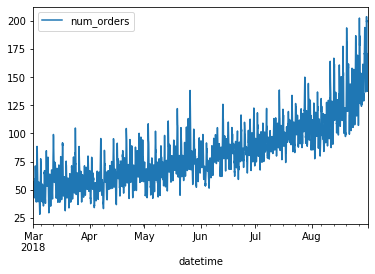

In [4]:
sgl = data.rolling(12).mean()
sgl.plot()

Мало что заметно на таком длинном временном промежутке, разве что наблюдается тенденция увеличения количества заказов от весны к осени. 

Для более точных выводов разложим временной ряд на тренды и сезонность.

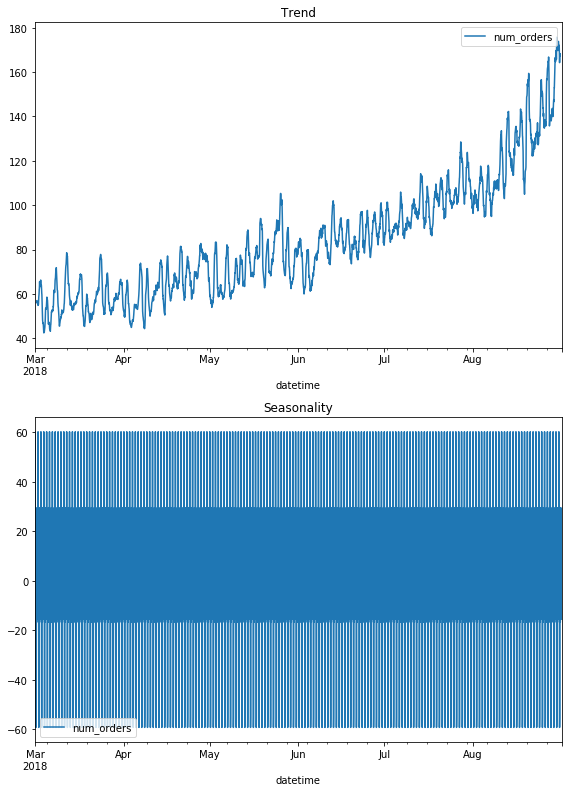

In [5]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
print()
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

На графике тренда показано, уже ранее замеченное нами плавное изменение.<br>
А вот с графиком сезонности не все так просто, слишком длинный временной промежуток. Поэтому для определения всех цикличностей отдельно рассмотрим составляющие этого интервала: сутки, недели.

**СУТКИ**

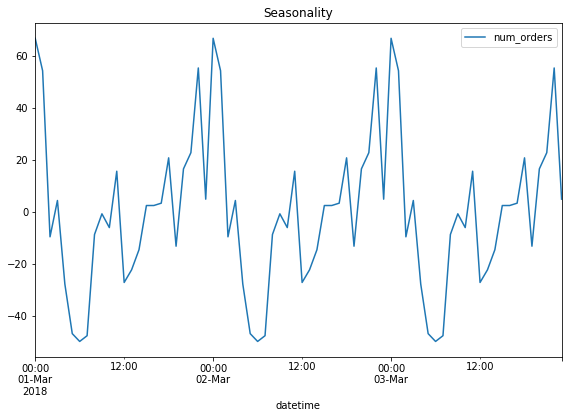

In [6]:
data_01 = data['2018-03-01':'2018-03-03'].resample('1H').mean()

decomposed = seasonal_decompose(data_01)
plt.figure(figsize=(8, 16))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Видим, что количество заказов в течение суток подходит к своему пику в полночь после чего резко снижается до минмума к 6 часам утра. Это сезонность по суткам. Посмотрим, что будет по дням недели.

**НЕДЕЛЯ**

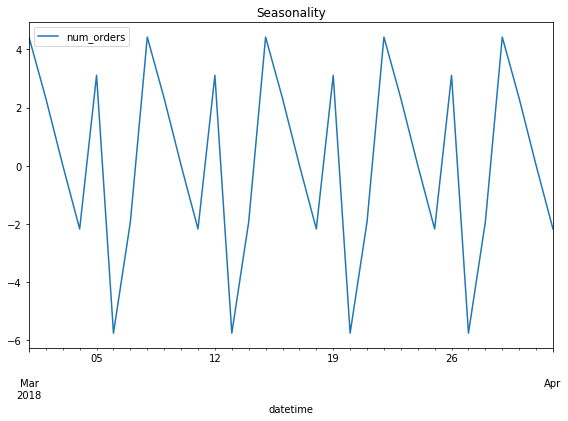

In [7]:
data_02 = data['2018-03-01':'2018-04-01'].resample('1D').mean()

decomposed = seasonal_decompose(data_02)
plt.figure(figsize=(8, 16))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

В случае с днями недели заметно, что количество заказов увеличивается со вторника по среду, далее уменьшается до субботы, и в воскресенье вновь набирает обороты. 

## Обучение

In [8]:
df = pd.DataFrame(index = data.index)#, columns = data.columns)
df['num_orders'] = data['num_orders']

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 10)

In [9]:
display(data)
display(df)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,173.3
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,166.6
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,162.9


Разделим выборки на обучающую, валидационную и тестовую. Будем делить исходя из равенства размеров выборок валидационной и тестовой. Плюс зная, что размер тестовой должен быть равен 10% от исходных данных, деление будет происходить в следующем соотношении 8:1:1.

Помним, что данные обучающей выборки должны предшествовать данным валидационной, а данные валидационной выборки должны предшествовать данным тестовой. Перемешивать данные нельзя.

In [10]:
train, valid = train_test_split(df, test_size = 0.2, shuffle = False)
valid, test = train_test_split(valid, test_size = 0.5, shuffle = False)
train = train.dropna()

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

Проверим, правильно ли разделились выборки

In [11]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(3508, 29)
(442, 29)
(442, 29)


Верно. Теперь проведем обучение на нескольких моделях с разными гиперпараметрами. У нас задача регрессии, надо предсказать числовой параметр. 

### Линейная регрессия

In [12]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)

valid_prediction = model.predict(features_valid)
print("RMSE валидационной выборки:", mean_squared_error(target_valid, valid_prediction)**0.5)

RMSE валидационной выборки: 34.15388704799759
CPU times: user 67.7 ms, sys: 123 ms, total: 190 ms
Wall time: 139 ms


Результат - 34,15 на "табло прибора". В то время, как на тестовой должно быть не больше 48. Обучим модель на случайном лесе.

### Случайный лес

In [13]:
%%time

best_est = 0
best_depth = 0
best_model = None
best_rmse = 1000
for est in range(5, 40, 5):
    for depth in range(1, 14):
        model_forest = RandomForestRegressor(random_state = 12345, max_depth = depth, n_estimators = est)
        model_forest.fit(features_train, target_train)
        prediction = model_forest.predict(features_valid)
        rmse = mean_squared_error(target_valid, prediction)**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model_forest
            best_est = est
            best_depth = depth

print("RMSE на валидационной выборке:", best_rmse, 'Глубина:', best_depth, ', Количество деревьев:', best_est)

RMSE на валидационной выборке: 32.349352935122866 Глубина: 11 , Количество деревьев: 25
CPU times: user 50.2 s, sys: 80.6 ms, total: 50.3 s
Wall time: 50.5 s


Немногим лучше. Посмотрим, как эта модель отработает на тестовых данных (в главе ниже). А сейчас едем дальше и попробуем обучить простую модель "Дерево решений".

### Дерево решений

In [14]:
%%time

best_depth = 0
best_model_01 = None
best_rmse = 1000
for depth in range(1, 20):
    model_tree = RandomForestRegressor(random_state = 12345, max_depth = depth)
    model_tree.fit(features_train, target_train)
    prediction = model_tree.predict(features_valid)
    rmse = mean_squared_error(target_valid, prediction)**0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_01 = model_tree
        best_depth = depth

print("RMSE:", best_rmse, 'Глубина:', best_depth)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

RMSE: 32.8698607618368 Глубина: 18
CPU times: user 6.8 s, sys: 24 ms, total: 6.82 s
Wall time: 6.88 s


Пока что застряли на значении - 33. Продолжим.

### LGBMRegressor

Напишем свой "scorer" для определения наилучших гиперпараметров, прогнав через GridSearchCV.

In [15]:
def rmse(target, prediction):
    rmse =  (np.sum(prediction - target)**2 / len(prediction))**0.5
    return rmse

rmse_scorer = make_scorer(rmse, greater_is_better = False)

Теперь LGBMRegressor. Определим наилучшие гиперпараметры.

In [16]:
%%time

model_lgb = LGBMRegressor()

param = {'n_estimators': [60, 200, 20],
        'num_leaves': [5, 27, 2]}

grid_gbm = GridSearchCV(model_lgb, param, cv=5, scoring = rmse_scorer)
grid_gbm.fit(features_train, target_train)
print(grid_gbm.best_estimator_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=27, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
CPU times: user 36.3 s, sys: 361 ms, total: 36.7 s
Wall time: 37.2 s


Запустим на валидационной выборке.

In [17]:
model_lgb_01 = LGBMRegressor(n_estimators=200, 
                             num_leaves=27, learning_rate=0.1)
model_lgb_01.fit(features_train, target_train)
pred_valid = model_lgb_01.predict(features_valid)
print("RMSE валидационной выборки:", mean_squared_error(target_valid, pred_valid)**0.5)

RMSE валидационной выборки: 31.62395823690101


### CatBoostRegressor

In [18]:
%%time

model_cat_01 = CatBoostRegressor(loss_function='RMSE', iterations=1000, learning_rate=0.1)
model_cat_01.fit(features_train, target_train, verbose=50)
pred_valid = model_cat_01.predict(features_valid)
print("RMSE валидационной выборки:", mean_squared_error(target_valid, pred_valid)**0.5)

0:	learn: 34.2878821	total: 50.7ms	remaining: 50.6s
50:	learn: 20.0367428	total: 1.44s	remaining: 26.7s
100:	learn: 18.1740219	total: 2.82s	remaining: 25.1s
150:	learn: 16.3862200	total: 4.29s	remaining: 24.1s
200:	learn: 14.9946347	total: 5.68s	remaining: 22.6s
250:	learn: 13.9507745	total: 7.15s	remaining: 21.3s
300:	learn: 12.9841588	total: 8.62s	remaining: 20s
350:	learn: 12.0074417	total: 10.1s	remaining: 18.7s
400:	learn: 11.2177056	total: 11.6s	remaining: 17.3s
450:	learn: 10.4760593	total: 13s	remaining: 15.8s
500:	learn: 9.7939678	total: 14.3s	remaining: 14.3s
550:	learn: 9.1940982	total: 15.7s	remaining: 12.8s
600:	learn: 8.6132323	total: 17.2s	remaining: 11.4s
650:	learn: 8.0737665	total: 18.6s	remaining: 9.95s
700:	learn: 7.6303071	total: 20s	remaining: 8.55s
750:	learn: 7.2093755	total: 21.4s	remaining: 7.1s
800:	learn: 6.8126133	total: 22.8s	remaining: 5.67s
850:	learn: 6.4026110	total: 24.3s	remaining: 4.25s
900:	learn: 6.0653716	total: 25.7s	remaining: 2.83s
950:	learn:

Итого: самые лучшие показатели у модели случайного леса с гиперпараметрами - Глубина: 13 , Количество деревьев: 30.

Спрогнозируем тестовый временной ряд при помощи этой модели.

## Тестирование

### Тест случайный лес

In [19]:
# model_forest = RandomForestRegressor(random_state = 12345, max_depth = 13, n_estimators = 35)
# model_forest.fit(features_train, target_train)
test_prediction = best_model.predict(features_test)
print("RMSE тестовой выборки:", mean_squared_error(target_test, test_prediction)**0.5)

RMSE тестовой выборки: 52.384488575261784


Плохие результаты. Следующий в списке по показателям RMSE  - линейная регрессия. Проверим ее на тестовой выборке.

### Тест линейная регрессия

In [20]:
test_prediction = model.predict(features_test)
print("RMSE тестовой выборки:", mean_squared_error(target_test, test_prediction)**0.5)

RMSE тестовой выборки: 46.47786623801484


### Тест дерево решений

In [21]:
test_prediction = best_model_01.predict(features_test)
print("RMSE тестовой выборки:", mean_squared_error(target_test, test_prediction)**0.5)

RMSE тестовой выборки: 53.834899859842196


Значение меньше нашего лучшего, полученного ранее даже при обучении случайного леса.

### Тест LGBMRegressor

In [22]:
model_lgb_01 = LGBMRegressor(n_estimators=200, 
                             num_leaves=27, learning_rate=0.1)
model_lgb_01.fit(features_train, target_train)
test_prediction = model_lgb_01.predict(features_test)
print("RMSE тестовой выборки:", mean_squared_error(target_test, test_prediction)**0.5)

RMSE тестовой выборки: 53.53400321500215


### Тест CatBoostRegressor

In [23]:
model_cat_01 = CatBoostRegressor(loss_function='RMSE', iterations=1000, learning_rate=0.1)
model_cat_01.fit(features_train, target_train, verbose=False)
test_prediction = model_cat_01.predict(features_test)
print("RMSE тестовой выборки:", mean_squared_error(target_test, test_prediction)**0.5)

RMSE тестовой выборки: 49.761675121397595


Отлично. Лучшей моделью в этом проекте стала линейная регрессия с RMSE в 46,5.<br>
Задача выполнена, учитывая, что необходимо было достичь RMSE менее 48.

## Выводы 

Анализ временных рядов показал, что идет тренд увеличения количества заказов такси от весны к осени. Интересно было бы узнать, почему так..

В том числе результаты анализа показали цикличность заказов в течение суток, где минимальные значения находятся у отметки в 6 часов утра, после чего наблюдается рост в течение дня, а пиковые показания - в полночь.<br>
Что касается дней недели, то частота вызова такси резко начинает расти с начала вторника до конца среды, после чего идет на спад, и вновь увеличивается в воскресный день. 

In [24]:
data['num_orders'].mean()

84.42278079710145

При среднем количестве заказов в 84 штуки обученная модель ошибается в среднем на добрую половину (RMSE лучшей модели 46,5). 

Результат можно посчитать удовлетворительным во времена пиковой нагрузки, где ошибка составит около 20%.